<a href="https://colab.research.google.com/github/SwamiFr/sincnet-cough/blob/main/Sincnet_Deneme_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive daki bilgileri local dataya aktarma


In [2]:
# Gerekli kütüphaneleri yükle
!pip install torchcodec
!pip install soundfile

import torch
import torchaudio
import os
import glob
import shutil
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import sys

print("Kütüphaneler yüklendi.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.6 MB/s eta 0:00:00
Kütüphaneler yüklendi.


In [3]:
import os
import shutil
from google.colab import drive
from tqdm import tqdm

# 1. Drive'ı bağla (Zaten bağlıysa tekrar sormaz)
drive.mount('/content/drive')

# 2. Kaynak Yolları (Senin verdiğin yollar)
# Sağlıklı verilerin olduğu klasör
healthy_source = '/content/drive/MyDrive/Colab Notebooks/İşaretlenenler/healthy/other'

# Astım verilerin olduğu klasör (İlk mesajındaki yola göre kök klasör)
asthma_source = '/content/drive/MyDrive/Colab Notebooks/İşaretlenenler/asthma'

# Hedef klasörler (Colab Local - Hızlı Disk)
base_target = '/content/dataset'
healthy_target_dir = os.path.join(base_target, 'healthy')
asthma_target_dir = os.path.join(base_target, 'asthma')

# Hedef klasörleri temizle ve yeniden oluştur
if os.path.exists(base_target):
    shutil.rmtree(base_target)
os.makedirs(healthy_target_dir)
os.makedirs(asthma_target_dir)

print("Dosyalar taranıyor ve kopyalanıyor...")

# Kopyalama Fonksiyonu
def copy_files(source_folder, target_folder, label_name):
    count = 0
    # os.walk alt klasörlerin hepsine girer (exth01, cough vb. fark etmez bulur)
    for root, dirs, files in os.walk(source_folder):
        for file in files:
            if file.lower().endswith('.wav'):
                src_path = os.path.join(root, file)
                dst_path = os.path.join(target_folder, file)

                # Dosya ismi çakışmasını önlemek için gerekirse isme ek yapabiliriz
                # Ama şimdilik direkt kopyalıyoruz
                shutil.copy(src_path, dst_path)
                count += 1
    print(f"-> '{label_name}' için kopyalanan dosya sayısı: {count}")
    return count

# İşlemi Başlat
h_count = copy_files(healthy_source, healthy_target_dir, "Sağlıklı (healthy)")
a_count = copy_files(asthma_source, asthma_target_dir, "Astım (asthma)")

print(f"\nİşlem Tamamlandı!")
print(f"Toplam Ses Dosyası: {h_count + a_count}")

# Hata kontrolü: Eğer hala 0 görünüyorsa yolu kontrol etmemiz gerekebilir
if h_count == 0:
    print(f"UYARI: '{healthy_source}' konumunda hiç .wav dosyası bulunamadı! Drive yolunu kontrol et.")
if a_count == 0:
    print(f"UYARI: '{asthma_source}' konumunda hiç .wav dosyası bulunamadı! Drive yolunu kontrol et.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dosyalar taranıyor ve kopyalanıyor...
-> 'Sağlıklı (healthy)' için kopyalanan dosya sayısı: 721
-> 'Astım (asthma)' için kopyalanan dosya sayısı: 346

İşlem Tamamlandı!
Toplam Ses Dosyası: 1067


Veri Yükleyici (Dataset) ve Eğitim/Test Ayrımı

In [4]:
# --- ADIM 2 GÜNCELLENDİ (AUGMENTATION EKLENDİ) ---
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import glob
import os
import numpy as np

SAMPLE_RATE = 16000
DURATION = 3
INPUT_LENGTH = SAMPLE_RATE * DURATION
BATCH_SIZE = 16

# Yollar (Senin yolların)
healthy_dir = '/content/dataset/healthy'
asthma_dir = '/content/dataset/asthma'

class CoughDataset(Dataset):
    def __init__(self, file_paths, labels, target_length, train_mode=False):
        self.file_paths = file_paths
        self.labels = labels
        self.target_length = target_length
        self.train_mode = train_mode # Eğitim modunda mı?

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = self.labels[idx]

        try:
            waveform, sr = torchaudio.load(path, backend="soundfile")
        except:
            waveform, sr = torchaudio.load(path)

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        if sr != SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(sr, SAMPLE_RATE)
            waveform = resampler(waveform)

        # Uzunluk sabitleme
        if waveform.shape[1] > self.target_length:
            waveform = waveform[:, :self.target_length]
        elif waveform.shape[1] < self.target_length:
            padding = self.target_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # --- AUGMENTATION (Sadece Eğitimde) ---
        # Modele sürekli aynı temiz sesi vermek yerine biraz gürültülü veriyoruz
        if self.train_mode:
            # 1. Gaussian Noise (Cızırtı ekle)
            if torch.rand(1).item() < 0.5: # %50 ihtimalle
                noise = torch.randn_like(waveform) * 0.005
                waveform = waveform + noise

            # 2. Amplitude Shift (Ses şiddetini rastgele değiştir)
            vol_factor = np.random.uniform(0.8, 1.2)
            waveform = waveform * vol_factor

        return waveform, label

# Dosya işlemleri aynı
healthy_files = glob.glob(os.path.join(healthy_dir, "*.wav"))
asthma_files = glob.glob(os.path.join(asthma_dir, "*.wav"))

X = healthy_files + asthma_files
y = [0] * len(healthy_files) + [1] * len(asthma_files)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Train dataset'e 'train_mode=True' dedik!
train_dataset = CoughDataset(X_train, y_train, INPUT_LENGTH, train_mode=True)
test_dataset = CoughDataset(X_test, y_test, INPUT_LENGTH, train_mode=False) # Test verisi saf kalmalı

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Veri seti 'Data Augmentation' ile güçlendirildi.")

Veri seti 'Data Augmentation' ile güçlendirildi.


SincNet Mimarisi

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class SincConv_fast(nn.Module):
    def __init__(self, out_channels, kernel_size, sample_rate=16000, in_channels=1,
                 min_low_hz=50, min_band_hz=50):
        super(SincConv_fast, self).__init__()

        if in_channels != 1:
            raise ValueError("SincConv sadece tek kanal giriş destekler.")

        self.out_channels = out_channels
        self.kernel_size = kernel_size

        # Simetri için kernel boyutu tek sayı olmalı
        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size + 1

        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # Mel-scale başlatma
        low_hz = 30
        high_hz = sample_rate / 2 - (min_low_hz + min_band_hz)

        mel = np.linspace(self.to_mel(low_hz), self.to_mel(high_hz), self.out_channels + 1)
        hz = self.to_hz(mel)

        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))
        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))

        # --- DÜZELTME BURADA YAPILDI ---
        # n_lin 0'dan başlarsa (sin(0)/0) hatası verir ve Loss NaN olur.
        # Bu yüzden 1'den başlatıyoruz. Merkez nokta (0) zaten aşağıda 'band_pass_center' ile hesaplanıyor.

        # Hamming penceresi
        n_lin = torch.linspace(1, (self.kernel_size / 2), int((self.kernel_size / 2))) # 0 yerine 1'den başlattık
        window_ = 0.54 - 0.46 * torch.cos(2 * np.pi * n_lin / self.kernel_size)

        # Zaman ekseni (n_)
        n_ = 2 * np.pi * n_lin / self.sample_rate
        n_ = n_.view(1, -1)

        # Buffer kayıt
        self.register_buffer('window_', window_)
        self.register_buffer('n_', n_)

    def to_mel(self, hz):
        return 2595 * np.log10(1 + hz / 700)

    def to_hz(self, mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def forward(self, waveforms):
        low = self.min_low_hz + torch.abs(self.low_hz_)
        high = torch.clamp(low + self.min_band_hz + torch.abs(self.band_hz_), self.min_low_hz, self.sample_rate / 2)
        band = (high - low)[:, 0]

        f_times_t_low = torch.matmul(low, self.n_)
        f_times_t_high = torch.matmul(high, self.n_)

        # Sinc fonksiyonu (Artık 0'a bölünme riski yok)
        band_pass_left = ((torch.sin(f_times_t_high) - torch.sin(f_times_t_low)) / (self.n_ / 2)) * self.window_
        band_pass_center = 2 * band.view(-1, 1)
        band_pass_right = torch.flip(band_pass_left, dims=[1])

        filters = torch.cat([band_pass_left, band_pass_center, band_pass_right], dim=1)
        filters = filters.view(self.out_channels, 1, self.kernel_size)

        return F.conv1d(waveforms, filters, stride=1, padding=self.kernel_size // 2)

# --- ADIM 3 GÜNCELLENDİ (DROPOUT EKLENDİ) ---
# SincConv_fast sınıfı aynı kalacak (Önceki mesajdaki son çalışan halini kullan),
# Sadece CoughSincNet'i değiştiriyoruz.

# (SincConv_fast kodunu buraya tekrar yapıştırmıyorum, önceki çalışan hali hafızada varsa yeterli.
# Eğer yoksa önceki cevaptan SincConv_fast kısmını da al.)

class CoughSincNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CoughSincNet, self).__init__()

        self.sinc_conv = SincConv_fast(out_channels=80, kernel_size=251, sample_rate=16000)
        self.layer_norm = nn.LayerNorm([80, INPUT_LENGTH])

        self.conv2 = nn.Conv1d(80, 60, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(60)
        self.pool2 = nn.MaxPool1d(3)

        self.conv3 = nn.Conv1d(60, 60, kernel_size=5)
        self.bn3 = nn.BatchNorm1d(60)
        self.pool3 = nn.MaxPool1d(3)

        self.flatten = nn.Flatten()

        with torch.no_grad():
             dummy = torch.zeros(1, 1, INPUT_LENGTH)
             x = self.sinc_conv(dummy)
             x = self.layer_norm(x)
             x = self.pool2(F.leaky_relu(self.bn2(self.conv2(x))))
             x = self.pool3(F.leaky_relu(self.bn3(self.conv3(x))))
             flatten_dim = x.shape[1] * x.shape[2]

        # --- DROPOUT EKLENDİ ---
        self.dropout = nn.Dropout(0.5) # Nöronların %50'sini kapat

        self.fc1 = nn.Linear(flatten_dim, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.leaky_relu(self.layer_norm(self.sinc_conv(x)))
        x = self.pool2(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.leaky_relu(self.bn3(self.conv3(x))))

        x = self.flatten(x)

        # Dropout'u buraya ekliyoruz
        x = self.dropout(x)

        x = F.leaky_relu(self.bn_fc1(self.fc1(x)))

        # Çıkıştan önce de biraz dropout koyabiliriz (opsiyonel ama iyi gelir)
        x = self.dropout(x)

        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CoughSincNet(num_classes=2).to(device)
print(f"Model Dropout katmanlarıyla güçlendirildi.")

Model Dropout katmanlarıyla güçlendirildi.


Eğitim (Training) Döngüsü

In [7]:
# --- ADIM 4: TAM EĞİTİM KODU (Early Stopping Dahil) ---
import torch.optim as optim
import torch.nn as nn
import copy
import sys
from tqdm import tqdm

# Öncelikle 'run_epoch' fonksiyonunu tanımlayalım (Hata veren kısım burasıydı)
def run_epoch(loader, is_train=True):
    model.train() if is_train else model.eval()
    total_loss = 0
    correct = 0
    total = 0

    # İlerleme çubuğu (Progress Bar)
    desc = "Eğitim" if is_train else "Test"
    loop = tqdm(loader, desc=desc, leave=False, file=sys.stdout)

    with torch.set_grad_enabled(is_train):
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            if is_train:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # NaN koruması
                if torch.isnan(loss):
                    continue

                loss.backward()
                # Gradient Clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader) if len(loader) > 0 else 0
    return avg_loss, 100 * correct / total

# --- Ayarlar ve Döngü ---
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
EPOCHS = 30

# Early Stopping Değişkenleri
patience = 5
best_loss = float('inf')
counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

print(f"--- GELİŞMİŞ EĞİTİM BAŞLIYOR (Cihaz: {device}) ---")

for epoch in range(EPOCHS):
    train_loss, train_acc = run_epoch(train_loader, is_train=True)
    test_loss, test_acc = run_epoch(test_loader, is_train=False)

    print(f"Epoch {epoch+1}/{EPOCHS} -> "
          f"Train Loss: {train_loss:.4f} | "
          f"Test Loss: {test_loss:.4f} (Acc: %{test_acc:.2f})")

    # Early Stopping Kontrolü
    if test_loss < best_loss:
        best_loss = test_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
        # En iyi modeli diske de kaydedelim
        torch.save(model.state_dict(), 'en_iyi_model.pth')
    else:
        counter += 1
        print(f"   -> İyileşme yok. Sayaç: {counter}/{patience}")
        if counter >= patience:
            print("--- ERKEN DURDURMA (EARLY STOPPING) ---")
            print("Model ezberlemeye (overfitting) başladı, eğitim durduruluyor.")
            break

# En iyi ağırlıkları geri yükle
model.load_state_dict(best_model_wts)
print(f"Eğitim bitti. En iyi model yüklendi. (Test Loss: {best_loss:.4f})")

--- GELİŞMİŞ EĞİTİM BAŞLIYOR (Cihaz: cuda) ---
Eğitim:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchaudio/__init__.py:86: UserWarning: The 'backend' parameter is not used by TorchCodec AudioDecoder.
  return load_with_torchcodec(


Epoch 1/30 -> Train Loss: 0.6892 | Test Loss: 0.4809 (Acc: %79.91)
Epoch 2/30 -> Train Loss: 0.3773 | Test Loss: 0.4554 (Acc: %79.44)
Epoch 3/30 -> Train Loss: 0.2892 | Test Loss: 0.4956 (Acc: %80.84)
   -> İyileşme yok. Sayaç: 1/5
Epoch 4/30 -> Train Loss: 0.2067 | Test Loss: 0.4739 (Acc: %80.84)
   -> İyileşme yok. Sayaç: 2/5
Epoch 5/30 -> Train Loss: 0.1321 | Test Loss: 0.4762 (Acc: %80.84)
   -> İyileşme yok. Sayaç: 3/5
Epoch 6/30 -> Train Loss: 0.1041 | Test Loss: 0.4667 (Acc: %80.84)
   -> İyileşme yok. Sayaç: 4/5
Epoch 7/30 -> Train Loss: 0.0696 | Test Loss: 0.4792 (Acc: %78.97)
   -> İyileşme yok. Sayaç: 5/5
--- ERKEN DURDURMA (EARLY STOPPING) ---
Model ezberlemeye (overfitting) başladı, eğitim durduruluyor.
Eğitim bitti. En iyi model yüklendi. (Test Loss: 0.4554)


grafik


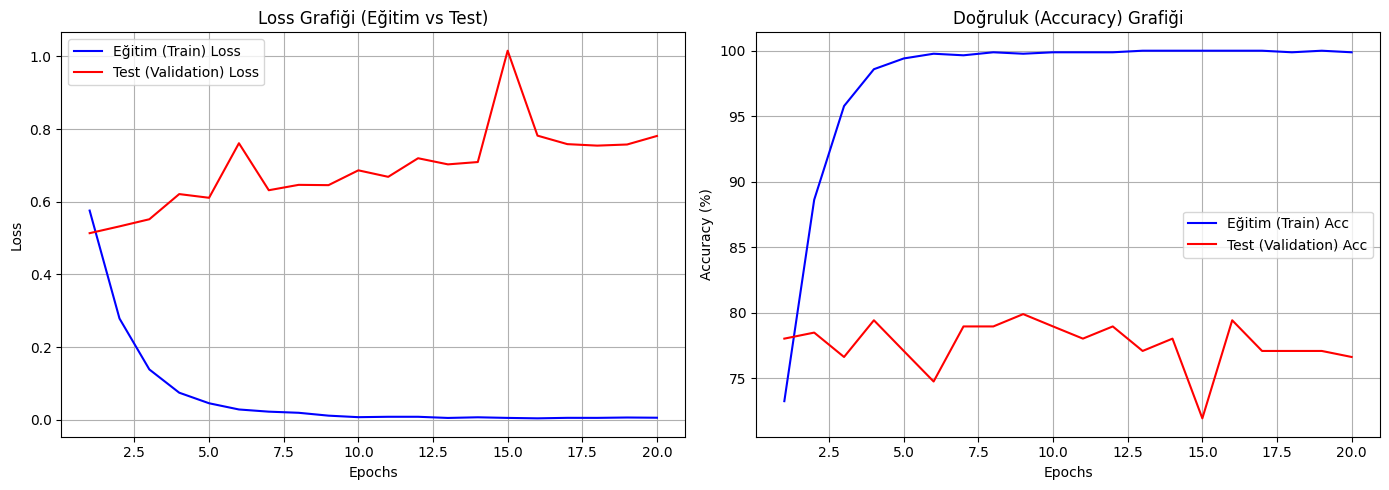

In [8]:
import matplotlib.pyplot as plt

# Senin attığın çıktılardan değerleri buraya girdim
epochs = range(1, 21)

train_loss = [0.5756, 0.2784, 0.1382, 0.0742, 0.0451, 0.0280, 0.0220, 0.0189,
              0.0110, 0.0068, 0.0079, 0.0079, 0.0047, 0.0065, 0.0048, 0.0036,
              0.0050, 0.0049, 0.0059, 0.0053]

test_loss = [0.5134, 0.5321, 0.5517, 0.6210, 0.6108, 0.7610, 0.6316, 0.6464,
             0.6456, 0.6864, 0.6685, 0.7197, 0.7028, 0.7092, 1.0157, 0.7819,
             0.7585, 0.7544, 0.7575, 0.7810]

train_acc = [73.27, 88.63, 95.78, 98.59, 99.41, 99.77, 99.65, 99.88,
             99.77, 99.88, 99.88, 99.88, 100.00, 100.00, 100.00, 100.00,
             100.00, 99.88, 100.00, 99.88]

test_acc = [78.04, 78.50, 76.64, 79.44, 77.10, 74.77, 78.97, 78.97,
            79.91, 78.97, 78.04, 78.97, 77.10, 78.04, 71.96, 79.44,
            77.10, 77.10, 77.10, 76.64]

# Grafik Boyutları
plt.figure(figsize=(14, 5))

# --- 1. Grafik: LOSS (Kayıp) ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Eğitim (Train) Loss')
plt.plot(epochs, test_loss, 'r-', label='Test (Validation) Loss')
plt.title('Loss Grafiği (Eğitim vs Test)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- 2. Grafik: ACCURACY (Doğruluk) ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Eğitim (Train) Acc')
plt.plot(epochs, test_acc, 'r-', label='Test (Validation) Acc')
plt.title('Doğruluk (Accuracy) Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Göster ve Kaydet
plt.tight_layout()
plt.savefig('egitim_sonuclari.png', dpi=300) # Yüksek kalitede kaydeder
plt.show()

SEgmente ve tahmin


In [9]:
import librosa
import torch
import torch.nn.functional as F
import numpy as np
import os

# Ayarlar
TARGET_SAMPLE_RATE = 16000
INPUT_LENGTH = 48000 # 3 saniye * 16000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def process_and_predict(segment, sr, model):
    """Tek bir ses parçasını modele sokar ve sonucu döndürür"""
    # 1. Tensor'a çevir
    tensor = torch.from_numpy(segment).float()

    # 2. Boyutlandırma (Padding veya Cutting)
    if tensor.shape[0] > INPUT_LENGTH:
        # Uzunsa ortadan kes
        center = tensor.shape[0] // 2
        start = center - (INPUT_LENGTH // 2)
        tensor = tensor[start : start + INPUT_LENGTH]
    elif tensor.shape[0] < INPUT_LENGTH:
        # Kısaysa sonuna sıfır ekle (Padding)
        padding = INPUT_LENGTH - tensor.shape[0]
        tensor = F.pad(tensor, (0, padding))

    # 3. Batch boyutu ve Kanal ekle [1, 1, 48000]
    input_tensor = tensor.unsqueeze(0).unsqueeze(0).to(DEVICE)

    # 4. Tahmin
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)

    return pred.item(), conf.item()

def analyze_audio_file(file_path):
    print(f"ANALİZ BAŞLIYOR: {file_path}")
    print("-" * 50)

    if not os.path.exists(file_path):
        print("HATA: Dosya bulunamadı! Yolu kontrol et.")
        return

    # 1. Dosyayı Yükle (Librosa ile)
    try:
        y, sr = librosa.load(file_path, sr=TARGET_SAMPLE_RATE)
    except Exception as e:
        print(f"Dosya okuma hatası: {e}")
        return

    # 2. Sessizlikleri At (Segmentation)
    # top_db=20: Gürültü eşiği (sessiz yerleri atar)
    intervals = librosa.effects.split(y, top_db=20)

    votes = {"healthy": 0, "asthma": 0}
    results_log = []

    print(f"Tespit edilen ses parçası (öksürük adayı) sayısı: {len(intervals)}\n")

    for i, (start, end) in enumerate(intervals):
        segment = y[start:end]

        # Çok kısa sesleri (0.2 saniyeden az) yoksay (tıkırtı vb.)
        if len(segment) < (0.2 * TARGET_SAMPLE_RATE):
            continue

        # Tahmin Yap
        label_idx, confidence = process_and_predict(segment, sr, model)

        # Etiketleme (0: Sağlıklı, 1: Astım)
        label_str = "SAĞLIKLI" if label_idx == 0 else "ASTIM"
        color = "\033[92m" if label_idx == 0 else "\033[91m" # Yeşil veya Kırmızı yazı
        reset = "\033[0m"

        print(f"Parça {i+1}: {color}{label_str}{reset} (Güven: %{confidence*100:.2f}) - Süre: {len(segment)/sr:.2f}sn")

        # Oylama (Sadece güveni %60'tan yüksek olanları say)
        if confidence > 0.60:
            if label_idx == 0:
                votes["healthy"] += 1
            else:
                votes["asthma"] += 1

        results_log.append(label_idx)

    # 3. Genel Sonuç
    print("-" * 50)
    print("GENEL RAPOR:")

    total_valid_votes = votes["healthy"] + votes["asthma"]

    if total_valid_votes == 0:
        print("Yeterli netlikte öksürük tespit edilemedi veya dosya boş.")
    else:
        asthma_ratio = (votes["asthma"] / total_valid_votes) * 100

        print(f"Astım Oyu: {votes['asthma']}")
        print(f"Sağlıklı Oyu: {votes['healthy']}")

        if votes["asthma"] > votes["healthy"]:
            print(f"\nSONUÇ: \033[91m⚠️ BU SES ASTIM BELİRTİLERİ GÖSTERİYOR ⚠️\033[0m")
        elif votes["healthy"] > votes["asthma"]:
            print(f"\nSONUÇ: \033[92m✅ BU SES SAĞLIKLI GÖRÜNÜYOR ✅\033[0m")
        else:
            print(f"\nSONUÇ: ⚖️ DURUM BELİRSİZ (Eşit oy)")

# --- ÇALIŞTIR ---
target_file = "/content/1 (58).wav"
analyze_audio_file(target_file)

ANALİZ BAŞLIYOR: /content/1 (58).wav
--------------------------------------------------
Tespit edilen ses parçası (öksürük adayı) sayısı: 2

Parça 1: SAĞLIKLI (Güven: %98.31) - Süre: 9.15sn
Parça 2: SAĞLIKLI (Güven: %85.91) - Süre: 5.42sn
--------------------------------------------------
GENEL RAPOR:
Astım Oyu: 0
Sağlıklı Oyu: 2

SONUÇ: ✅ BU SES SAĞLIKLI GÖRÜNÜYOR ✅


In [10]:
import pandas as pd
import librosa
import torch
import torch.nn.functional as F
import os
import numpy as np

# --- AYARLAR ---
audio_path = "/content/1 (58).wav"  # Ses dosyasının yolu
csv_path = "/content/1 (58).csv"    # CSV dosyasının yolu
TARGET_SAMPLE_RATE = 16000
INPUT_LENGTH = 48000 # 3 saniye
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- ÖNCEKİ TAHMİN FONKSİYONU (Hazır dursun) ---
def process_and_predict_segment(segment, sr, model):
    tensor = torch.from_numpy(segment).float()

    # 3 Saniyeye tamamla veya kes
    if tensor.shape[0] > INPUT_LENGTH:
        center = tensor.shape[0] // 2
        start = center - (INPUT_LENGTH // 2)
        tensor = tensor[start : start + INPUT_LENGTH]
    elif tensor.shape[0] < INPUT_LENGTH:
        padding = INPUT_LENGTH - tensor.shape[0]
        tensor = F.pad(tensor, (0, padding))

    input_tensor = tensor.unsqueeze(0).unsqueeze(0).to(DEVICE)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)

    return pred.item(), conf.item()

# --- CSV İLE KESİN ANALİZ ---
def analyze_with_csv(audio_file, annotation_file):
    print(f"CSV DOĞRULAMALI ANALİZ BAŞLIYOR...")
    print(f"Ses: {audio_file}")
    print(f"Veri: {annotation_file}")
    print("-" * 60)

    # Dosyaları Yükle
    if not os.path.exists(audio_file) or not os.path.exists(annotation_file):
        print("HATA: Ses veya CSV dosyası bulunamadı!")
        return

    y, sr = librosa.load(audio_file, sr=TARGET_SAMPLE_RATE)
    df = pd.read_csv(annotation_file)

    votes = {"healthy": 0, "asthma": 0}

    print(f"CSV içinde {len(df)} adet etiketli öksürük bulundu.\n")

    # Her satırı tek tek işle
    for index, row in df.iterrows():
        start_time = row['StartTime']
        end_time = row['EndTime']

        # Saniyeyi sample sayısına çevir (Örn: 1.5 sn * 16000 = 24000. sample)
        start_sample = int(start_time * sr)
        end_sample = int(end_time * sr)

        # Sesi kes
        segment = y[start_sample:end_sample]

        # Eğer çok kısaysa (CSV hatası vs) atla
        if len(segment) < 100:
            print(f"Satır {index+1}: Ses çok kısa, atlanıyor.")
            continue

        # Modele Sor
        label_idx, confidence = process_and_predict_segment(segment, sr, model)

        # Çıktıyı hazırla
        label_str = "SAĞLIKLI" if label_idx == 0 else "ASTIM"
        color = "\033[92m" if label_idx == 0 else "\033[91m" # Yeşil/Kırmızı
        reset = "\033[0m"

        print(f"Öksürük {index+1} ({start_time}-{end_time}s): {color}{label_str}{reset} (Güven: %{confidence*100:.2f})")

        if label_idx == 0:
            votes["healthy"] += 1
        else:
            votes["asthma"] += 1

    # GENEL SONUÇ
    print("-" * 60)
    print(f"TOPLAM SONUÇ: {votes['asthma']} Astım vs {votes['healthy']} Sağlıklı")

    if votes["asthma"] > votes["healthy"]:
        print(f"\nSONUÇ: \033[91m⚠️ BU HASTA ASTIM (CSV Verisine Göre) ⚠️\033[0m")
    elif votes["healthy"] > votes["asthma"]:
        print(f"\nSONUÇ: \033[92m✅ BU HASTA SAĞLIKLI ⚠️\033[0m")
    else:
        print(f"\nSONUÇ: ⚖️ Eşitlik var.")

# Çalıştır
analyze_with_csv(audio_path, csv_path)

CSV DOĞRULAMALI ANALİZ BAŞLIYOR...
Ses: /content/1 (58).wav
Veri: /content/1 (58).csv
------------------------------------------------------------
CSV içinde 11 adet etiketli öksürük bulundu.

Öksürük 1 (1.94-2.417s): ASTIM (Güven: %78.98)
Öksürük 2 (2.458-3.016s): ASTIM (Güven: %68.06)
Öksürük 3 (3.616-4.106s): ASTIM (Güven: %99.84)
Öksürük 4 (4.15-4.599s): ASTIM (Güven: %99.97)
Öksürük 5 (4.883-5.537s): ASTIM (Güven: %99.32)
Öksürük 6 (5.805-6.263s): ASTIM (Güven: %99.64)
Öksürük 7 (6.996-7.508s): ASTIM (Güven: %98.88)
Öksürük 8 (9.065-9.568s): ASTIM (Güven: %94.30)
Öksürük 9 (11.365-11.935s): ASTIM (Güven: %99.38)
Öksürük 10 (14.588-15.181s): ASTIM (Güven: %100.00)
Öksürük 11 (15.318-15.881s): ASTIM (Güven: %99.65)
------------------------------------------------------------
TOPLAM SONUÇ: 11 Astım vs 0 Sağlıklı

SONUÇ: ⚠️ BU HASTA ASTIM (CSV Verisine Göre) ⚠️


In [11]:
import librosa
import torch
import torch.nn.functional as F
import numpy as np
import os
from scipy.signal import butter, lfilter

# --- AYARLAR ---
TARGET_SAMPLE_RATE = 16000
INPUT_LENGTH = 48000 # 3 saniye
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Test edilecek dosya yolu
raw_audio_path = "/content/1 (58).wav"

# --- SİNYAL İŞLEME FONKSİYONLARI ---
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Sesi filtreler: Sadece öksürük frekanslarını bırakır."""
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def smart_segmentation(y, sr):
    """
    Sesi analiz eder ve öksürük olabilecek aralıkları döndürür.
    Gürültüyü değil, patlayıcı sesleri (öksürük) hedefler.
    """
    # 1. Önce sesi temizle (200Hz - 4000Hz arası insan sesi/öksürük aralığıdır)
    y_filtered = butter_bandpass_filter(y, 200, 4000, sr, order=4)

    # 2. Hassas ayırma (Top_db'yi düşürdükçe hassasiyet artar)
    # frame_length: Analiz penceresi. Küçük olması anlık patlamaları yakalar.
    intervals = librosa.effects.split(y_filtered, top_db=25, frame_length=1024, hop_length=256)

    valid_intervals = []
    for start, end in intervals:
        duration = (end - start) / sr
        # 0.2 saniyeden kısa sesleri (çıtırtı) ve 2 saniyeden uzunları (konuşma olabilir) filtrele
        if duration > 0.15 and duration < 2.5:
            valid_intervals.append((start, end))

    return valid_intervals

# --- TAHMİN FONKSİYONU ---
def predict_segment(segment, sr, model):
    tensor = torch.from_numpy(segment).float()

    # 3 Saniye Ayarı
    if tensor.shape[0] > INPUT_LENGTH:
        center = tensor.shape[0] // 2
        start = center - (INPUT_LENGTH // 2)
        tensor = tensor[start : start + INPUT_LENGTH]
    elif tensor.shape[0] < INPUT_LENGTH:
        padding = INPUT_LENGTH - tensor.shape[0]
        tensor = F.pad(tensor, (0, padding))

    input_tensor = tensor.unsqueeze(0).unsqueeze(0).to(DEVICE)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)
    return pred.item(), conf.item()

# --- ANA ÇALIŞTIRMA ---
def auto_analyze(file_path):
    print(f"OTOMATİK ANALİZ BAŞLIYOR: {os.path.basename(file_path)}")

    if not os.path.exists(file_path):
        print("HATA: Dosya bulunamadı.")
        return

    # Sesi yükle
    y, sr = librosa.load(file_path, sr=TARGET_SAMPLE_RATE)

    # Akıllı Segmentasyon Yap
    intervals = smart_segmentation(y, sr)

    print(f"Filtreleme sonrası tespit edilen öksürük sayısı: {len(intervals)}")
    print("-" * 50)

    votes = {"healthy": 0, "asthma": 0}

    for i, (start, end) in enumerate(intervals):
        # DİKKAT: Filtrelenmiş sesi değil, ORİJİNAL sesi kesiyoruz
        segment = y[start:end]

        # Tahmin
        label_idx, confidence = predict_segment(segment, sr, model)

        label_str = "SAĞLIKLI" if label_idx == 0 else "ASTIM"
        color = "\033[92m" if label_idx == 0 else "\033[91m"
        reset = "\033[0m"

        # Süre hesapla
        dur = (end - start) / sr
        time_mark = f"{start/sr:.1f}s - {end/sr:.1f}s"

        print(f"[{i+1}] {time_mark} ({dur:.2f}sn) -> {color}{label_str}{reset} (Güven: %{confidence*100:.1f})")

        # Sadece güveni yüksek olanları oylamaya kat
        if confidence > 0.60:
            if label_idx == 0: votes["healthy"] += 1
            else: votes["asthma"] += 1

    # SONUÇ
    print("-" * 50)
    print(f"OYLAMA SONUCU: {votes['asthma']} Astım - {votes['healthy']} Sağlıklı")

    if votes["asthma"] > votes["healthy"]:
        print(f"GENEL TANI: \033[91mASTIM BELİRTİLERİ\033[0m")
    elif votes["healthy"] > votes["asthma"]:
        print(f"GENEL TANI: \033[92mSAĞLIKLI\033[0m")
    else:
        print("GENEL TANI: BELİRSİZ")

# Çalıştır
auto_analyze(raw_audio_path)

OTOMATİK ANALİZ BAŞLIYOR: 1 (58).wav
Filtreleme sonrası tespit edilen öksürük sayısı: 15
--------------------------------------------------
[1] 1.1s - 1.3s (0.24sn) -> ASTIM (Güven: %95.2)
[2] 2.0s - 2.7s (0.72sn) -> ASTIM (Güven: %95.4)
[3] 2.8s - 3.0s (0.21sn) -> SAĞLIKLI (Güven: %85.3)
[4] 3.6s - 3.9s (0.24sn) -> ASTIM (Güven: %92.0)
[5] 3.9s - 4.1s (0.21sn) -> ASTIM (Güven: %72.6)
[6] 4.2s - 4.4s (0.27sn) -> ASTIM (Güven: %98.8)
[7] 4.9s - 5.5s (0.64sn) -> ASTIM (Güven: %98.2)
[8] 5.8s - 6.3s (0.50sn) -> ASTIM (Güven: %98.4)
[9] 7.0s - 7.5s (0.48sn) -> ASTIM (Güven: %98.1)
[10] 9.1s - 9.6s (0.53sn) -> ASTIM (Güven: %88.5)
[11] 11.4s - 11.9s (0.56sn) -> ASTIM (Güven: %98.8)
[12] 14.6s - 15.0s (0.40sn) -> ASTIM (Güven: %99.8)
[13] 15.3s - 15.6s (0.29sn) -> ASTIM (Güven: %93.4)
[14] 15.6s - 15.9s (0.21sn) -> ASTIM (Güven: %68.9)
[15] 16.2s - 16.4s (0.16sn) -> ASTIM (Güven: %74.3)
--------------------------------------------------
OYLAMA SONUCU: 14 Astım - 1 Sağlıklı
GENEL TANI: ASTIM 

In [12]:
# Test edilecek yeni dosya yolu
target_file = "/content/2 (66).wav"

# Fonksiyonu çağır (Önceki hücredeki fonksiyon hafızada duruyor, tekrar tanımlamaya gerek yok)
if 'auto_analyze' in globals():
    auto_analyze(target_file)
else:
    print("HATA: Önceki analiz kodunu (def auto_analyze...) içeren hücreyi çalıştırmamışsın. Lütfen yukarı çıkıp o uzun kodu bir kere çalıştır.")

OTOMATİK ANALİZ BAŞLIYOR: 2 (66).wav
Filtreleme sonrası tespit edilen öksürük sayısı: 6
--------------------------------------------------
[1] 0.9s - 1.2s (0.27sn) -> SAĞLIKLI (Güven: %85.8)
[2] 1.6s - 1.9s (0.30sn) -> SAĞLIKLI (Güven: %95.8)
[3] 2.1s - 2.4s (0.32sn) -> SAĞLIKLI (Güven: %97.0)
[4] 3.1s - 3.5s (0.35sn) -> SAĞLIKLI (Güven: %93.6)
[5] 4.9s - 5.4s (0.48sn) -> SAĞLIKLI (Güven: %81.9)
[6] 5.7s - 5.8s (0.16sn) -> SAĞLIKLI (Güven: %83.2)
--------------------------------------------------
OYLAMA SONUCU: 0 Astım - 6 Sağlıklı
GENEL TANI: SAĞLIKLI
